In [282]:
import collections
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats

from linear_geodesic_optimization.data import input_network
from linear_geodesic_optimization.data import utility


epsilon = 22
postprocessed = False
remove_TIVs = False
# directory = os.path.join(os.sep, 'home', 'jasina', f'out_US_IEEE_{epsilon}')
# subdirectory = os.path.join(
#     directory,
#     '2023-08-27T12_00_00_2023-08-28T00_00_00_US',
#     '1.0_0.002_0.0_20.0_50_50_1.0'
# )
directory = os.path.join('..', f'out_US_IEEE_{epsilon}')
subdirectory = os.path.join(
    directory,
    '1.0_0.002_0.0_20.0_50_50_1.0'
)

def read_from_directory(directory):
    with open(os.path.join(directory, 'parameters'), 'rb') as f:
        parameters = pickle.load(f)
        latencies_file_path = os.path.join('..', 'data', parameters['latencies_filename'])
        probes_file_path = os.path.join('..', 'data', parameters['probes_filename'])
        epsilon = parameters['epsilon']
        clustering_distance = parameters['clustering_distance']

        graph = input_network.get_graph(probes_file_path, latencies_file_path, epsilon, clustering_distance, remove_TIVs)
        graph_complete = input_network.get_graph(probes_file_path, latencies_file_path, should_remove_tivs=remove_TIVs)

    latencies = {}
    gcls = {}
    for source_id, target_id, data in graph_complete.edges(data=True):
        latencies[(source_id, target_id)] = data['rtt']
        gcls[(source_id, target_id)] = data['gcl']

    geodesics = {}
    with open(os.path.join(directory, f"geodesics{'_postprocessed' if postprocessed else ''}.csv"), 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            geodesics[(row['source'], row['destination'])] = float(row['geodesic_distance'])

    return latencies, gcls, geodesics, graph

In [283]:
latencies, gcls, geodesics, graph = read_from_directory(subdirectory)

id_to_node = {}
for node, data in graph.nodes(data=True):
    for id in data['elements']:
        id_to_node[id] = node

valid_keys = [
    (a, b) if (a, b) in latencies else (b, a)
    for (a, b) in graph.edges
    if ((a, b) in latencies or (b, a) in latencies) and (a, b) in geodesics
]

latencies = {
    key: latencies[key]
    for key in valid_keys
}
gcls = {
    key: gcls[key]
    for key in valid_keys
}
geodesics = {
    key: geodesics[key]
    for key in valid_keys
}

gcls r^2 is 0.7716423910429849
geodesics r^2 is 0.7664397756462762


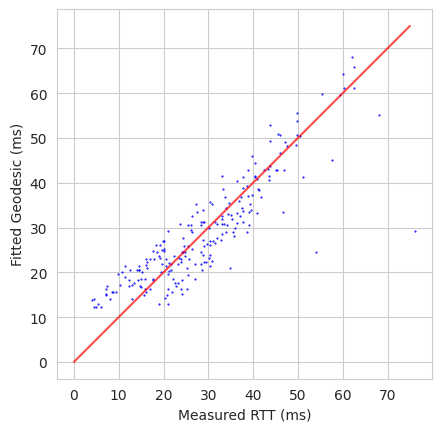

In [284]:
x_latencies = np.array([
    latencies[key]
    for key in valid_keys
])

y_gcls = np.array([
    gcls[key]
    for key in valid_keys
])
res_gcls = stats.linregress(y_gcls, x_latencies)
y_gcls = y_gcls * res_gcls.slope + res_gcls.intercept
print(f'gcls r^2 is {res_gcls.rvalue**2}')

y_geodesics = np.array([
    geodesics[key]
    for key in valid_keys
])
res_geodesics = stats.linregress(y_geodesics, x_latencies)
y_geodesics = y_geodesics * res_geodesics.slope + res_geodesics.intercept
print(f'geodesics r^2 is {res_geodesics.rvalue**2}')

plt.plot(x_latencies, y_geodesics, 'b.', markersize=1)
plt.plot([0, 75], [0, 75], 'r', alpha=0.7)
plt.xlabel('Measured RTT (ms)')
plt.ylabel('Fitted Geodesic (ms)')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"scatter{'_postprocessed' if postprocessed else ''}_{epsilon}.png", dpi=300)
plt.show()

geodesics r^2 is 0.985776000534578


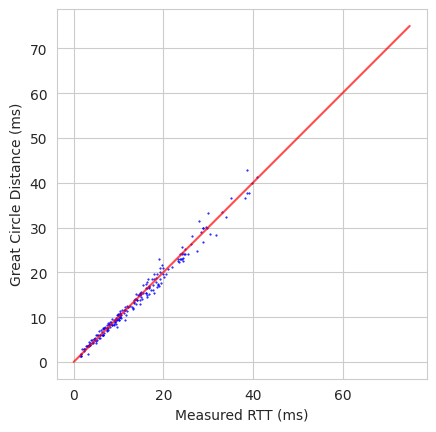

In [285]:
x_gcls = np.array([
    gcls[key]
    for key in valid_keys
])

y_geodesics = np.array([
    geodesics[key]
    for key in valid_keys
])
res_geodesics = stats.linregress(y_geodesics, x_gcls)
y_geodesics = y_geodesics * res_geodesics.slope + res_geodesics.intercept
print(f'geodesics r^2 is {res_geodesics.rvalue**2}')

plt.plot(x_gcls, y_geodesics, 'b.', markersize=1)
plt.plot([0, 75], [0, 75], 'r', alpha=0.7)
plt.xlabel('Measured RTT (ms)')
plt.ylabel('Great Circle Distance (ms)')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

('6274', '6644'): 4.262943967181002
('6274', '6287'): 3.738934049313592
('6274', '6343'): 3.6204858345558115
('6101', '6452'): 3.558867502644812
('6274', '6418'): 3.2279940913358125
('6452', '6835'): 2.8793967548518182
('6437', '6452'): 2.4325975226842544
('6343', '6452'): 2.0708318526781646
('6452', '6781'): 2.029622744081088
('6452', '6769'): 2.0177934960864565


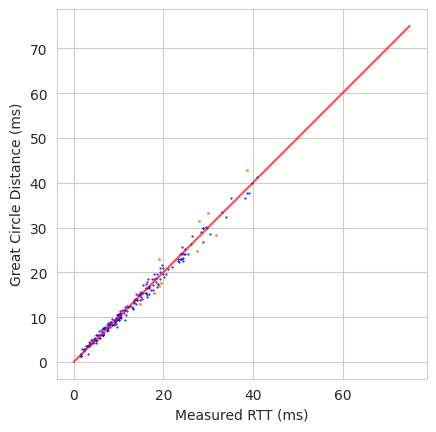

In [286]:
residuals = {
    key: (geodesics[key] * res_geodesics.slope + res_geodesics.intercept) - gcls[key]
    for key in valid_keys
}
top_residuals = {
    key: value
    for (value, key), _ in zip(sorted([
        (np.abs(v), k)
        for k, v in residuals.items()
    ], reverse=True), range(10))
}
for (key, value) in top_residuals.items():
    print(f'{key}: {value}')

plt.plot(x_gcls, y_geodesics, 'b.', markersize=1)
plt.plot(
    [gcls[key] for key in top_residuals],
    [geodesics[key] * res_geodesics.slope + res_geodesics.intercept for key in top_residuals],
    'o', color='orange', markersize=1)
plt.plot([0, 75], [0, 75], 'r', alpha=0.7)
plt.xlabel('Measured RTT (ms)')
plt.ylabel('Great Circle Distance (ms)')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [287]:
directory = os.path.join(os.sep, 'home', 'jasina', f'out_US_IEEE_{epsilon}')

all_fitted_geodesics = collections.defaultdict(list)
for subdirectory in os.listdir(directory):
    subdirectory = os.path.join(directory, subdirectory)
    subsubdirectory = os.path.join(subdirectory, os.listdir(subdirectory)[0])

    latencies, gcls, geodesics, graph = read_from_directory(subsubdirectory)

    id_to_node = {}
    for node, data in graph.nodes(data=True):
        for id in data['elements']:
            id_to_node[id] = node
    valid_keys = [
        (source_id, target_id)
        for (source_id, target_id) in latencies
        if source_id in id_to_node and target_id in id_to_node
    ]

    x_latencies = np.array([
        latencies[(source_id, target_id)]
        for (source_id, target_id) in valid_keys
    ])
    y_geodesics = np.array([
        geodesics[(id_to_node[source_id], id_to_node[target_id])]
        for (source_id, target_id) in valid_keys
    ])
    res_geodesics = stats.linregress(y_geodesics, x_latencies)

    for (source_id, target_id) in valid_keys:
        all_fitted_geodesics[(source_id, target_id)].append(
            geodesics[(id_to_node[source_id], id_to_node[target_id])] * res_geodesics.slope + res_geodesics.intercept
        )

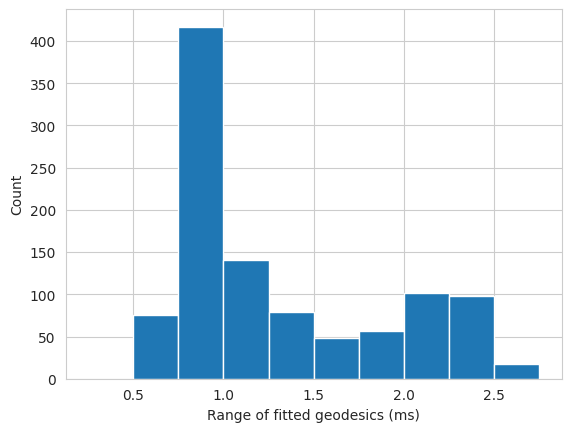

In [288]:
ranges = [
    max(s) - min(s)
    for s in all_fitted_geodesics.values()
]

plt.hist(ranges, bins=np.arange(0.25, 3, 0.25))
plt.xlabel('Range of fitted geodesics (ms)')
plt.ylabel('Count')
plt.savefig('ranges.png', dpi=300)
plt.show()

In [269]:
id_la = '6492'
id_nyc = '6549'

s = all_fitted_geodesics[(id_la, id_nyc)]
print(max(s) - min(s))

2.266113544096058
